In [2]:
%pip install pandas
%pip install numpy
%pip install regex
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import sys
import os
import regex

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict

import time
import datetime

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import matplotlib.pyplot as plt
import random

# Model Initialize

In [4]:
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(max_iter=1_000_000),
    "Ridge": Ridge(max_iter=1_000_000),
    "Elastic Net": ElasticNet(max_iter=1_000_000),
    "Regression Tree": DecisionTreeRegressor(),
    "Random Forest Reg": RandomForestRegressor()
}
cv = cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [5]:
def Rsq_adj(score, n, p):
    return 1 - (1-score)*n/(n-p-1)

def var_err(y_true, y_pred):
    return np.var((y_true - y_pred))

def data_loader(filename, ma=None, minmax=False):
    #print(filename)
    df = pd.read_csv(filename)
    df = df.drop(columns=["date"])
    df = df.dropna(axis=0)
    if ma:
        df = df.rolling(ma).mean()
        df = df.dropna().reset_index(drop=True)

    y = df.iloc[:,0]
    X = df.iloc[:,1:].dropna(axis=1)
    if minmax:
        #print(X)
        scaler = MinMaxScaler()
        X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
        
    return X, y

# Generate Score Analysis

In [6]:
for filling, filedir in [("distance", r"..\..\data\Combined_data_for_recreate\distance"),("cluster", r"..\..\data\Combined_data_for_recreate\cluster")]:
    
    city_files_NO2 = [x for x in os.listdir(filedir)  if regex.match(".*_NO2.csv", x)]
    city_files_SO2 = [x for x in os.listdir(filedir)  if regex.match(".*_SO2.csv", x)]
    city_files_PM25 = [x for x in os.listdir(filedir)  if regex.match(".*_PM25.csv", x)]
    city_files_CO = [x for x in os.listdir(filedir)  if regex.match(".*_CO.csv", x)]
    NO2 = {}
    SO2 = {}  
    PM25 = {}
    CO = {}
    NO2_scores = {}
    SO2_scores = {}
    PM25_scores = {}
    CO_scores = {}
    for gas, record_dict, scores_dict, gas_name in [(city_files_NO2, NO2, NO2_scores, "NO2"), (city_files_SO2, SO2, SO2_scores, "SO2"), (city_files_PM25, PM25, PM25_scores, "PM25"), (city_files_CO, CO, CO_scores, "CO")]:
        for file in gas:
            time_start = time.time()
            record = {}
            for ma in [None, 7]:
                X, y = data_loader(filedir+"/"+file, ma=None, minmax=True)
                record["num_features"] = len(X.columns)
                record["num_records"] = len(X)
                for model_name, model in models.items():
                    model.fit(X, y)
                    
                    if ma:
                        model_name = f"{model_name}_ma{ma}"
                

                    for metric_name, metric in {"R2":"r2", "MAE":"neg_mean_absolute_error", "VarOfErr":var_err}.items():
                        if metric_name == "VarOfErr":
                            record[f"{model_name}_{metric_name}"] = var_err(y, cross_val_predict(Lasso().fit(X, y), X, y, cv=cv))
                            continue
                        
                        score_array = cross_val_score(model, X, y, scoring=metric,
                                                    cv=cv, n_jobs=-1)
                        if metric_name == "MAE":
                            score_array = - score_array
                            
                        mask = np.logical_or(score_array == score_array.max(), score_array == score_array.min())
                        scores = np.ma.masked_array(score_array, mask = mask)
                        record[f"{model_name}_{metric_name}"] = scores.mean()
                        scores_dict[file.split(".csv")[0]+f"_{model_name}_{metric_name}"] = scores
                        #record[f"{model_name}_{metric_name}"] = score

        
            record_dict[file.split(f"_{gas_name}.csv")[0]+f"_{gas_name}"] = record
            time_elapsd = time.time()-time_start
            print(file.split(f"_{gas_name}.csv")[0]+f"_{gas_name} Finished, time used: {time_elapsd:.2f} seconds")
        df = pd.DataFrame(record_dict)
        df.to_csv(f"../../data/API Recreate/model_score/{filling}_{gas_name}.csv")
        print(filling, "finished")
        

Agartala_NO2 Finished, time used: 4.62 seconds
Agra_NO2 Finished, time used: 1.58 seconds
Aizwal_NO2 Finished, time used: 1.23 seconds
Amritsar_NO2 Finished, time used: 1.25 seconds
Asansol_NO2 Finished, time used: 1.28 seconds
Aurangabad_NO2 Finished, time used: 1.37 seconds
Bareilly_NO2 Finished, time used: 1.31 seconds
Belgaum_NO2 Finished, time used: 1.28 seconds
Bengaluru_NO2 Finished, time used: 1.86 seconds
Bhopal_NO2 Finished, time used: 1.25 seconds
Chandigarh_NO2 Finished, time used: 1.41 seconds
Chennai_NO2 Finished, time used: 1.75 seconds
Coimbatore_NO2 Finished, time used: 1.31 seconds
Dehradun_NO2 Finished, time used: 1.25 seconds
Delhi_NO2 Finished, time used: 3.96 seconds
Faridabad_NO2 Finished, time used: 1.44 seconds
Gandhinagar_NO2 Finished, time used: 1.30 seconds
Gangtok_NO2 Finished, time used: 1.31 seconds
Ghaziabad_NO2 Finished, time used: 1.36 seconds
Gorakhpur_NO2 Finished, time used: 1.29 seconds
Gwalior_NO2 Finished, time used: 1.31 seconds
Hyderabad_NO2 Fi

# Further Analysis and Visualization

C:\Users\Deyao Kong\AppData\Local\Temp\ipykernel_49544\1280988182.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = temp[random.sample(sorted(cols),6)].hist(ax=fig.gca(), layout = (3,2))


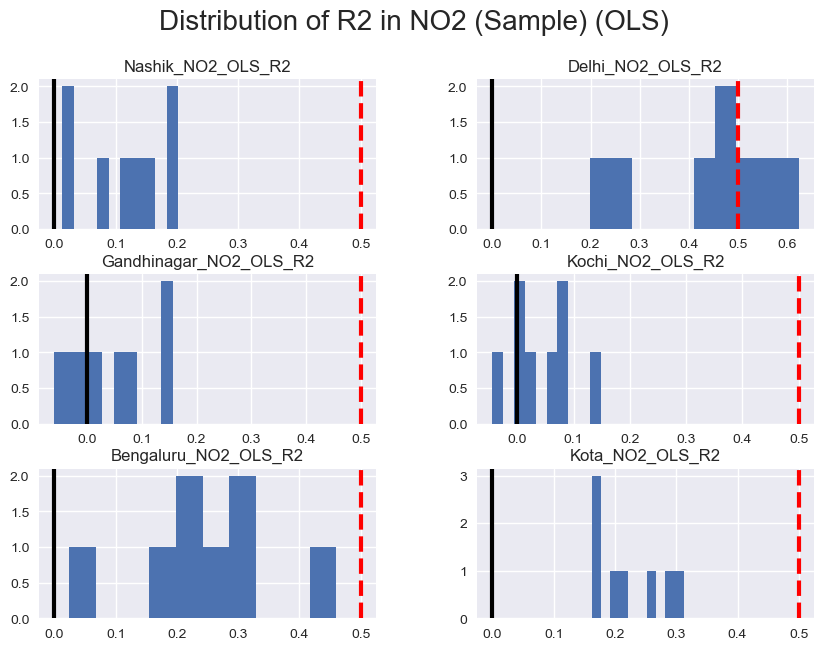

In [30]:
plt.style.use("seaborn")
temp=pd.DataFrame(NO2_scores)
cols = temp.columns[[bool(regex.match(".*OLS_R2", x)) for x in temp.columns]]
fig = plt.figure(figsize=(10,7))
axs = temp[random.sample(sorted(cols),6)].hist(ax=fig.gca(), layout = (3,2))
plt.suptitle("Distribution of R2 in NO2 (Sample) (OLS)", fontsize=20)
for ax in axs.flatten():
    ax.axvline(x=0, c="black", linewidth=3)
    ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
plt.show()

In [31]:

plt.style.use("seaborn")
temp=pd.DataFrame(NO2_scores)
cols = temp.columns[[bool(regex.match(".*Random Forest Reg_R2", x)) for x in temp.columns]]
fig = plt.figure(figsize=(10,7))
axs = temp[random.sample(sorted(cols),6)].hist(ax=fig.gca(), layout = (3,2))
plt.suptitle("Distribution of R2 in NO2 (Sample) (RF)", fontsize=20)
for ax in axs.flatten():
    ax.axvline(x=0, c="black", linewidth=3)
    ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
plt.show()

C:\Users\Deyao Kong\AppData\Local\Temp\ipykernel_49544\3650008146.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = temp[random.sample(sorted(cols),6)].hist(ax=fig.gca(), layout = (3,2))


In [9]:
SO2_df = pd.DataFrame(SO2)
NO2_df = pd.DataFrame(NO2)

C:\Users\Deyao Kong\AppData\Local\Temp\ipykernel_49544\4294091205.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = NO2_df.loc[[bool(regex.match(".*_R2",x)) for x in list(NO2_df.index)]].T.hist(ax=plt.gca(), layout=(6,2))


Text(0.5, 1.0, 'NO2')

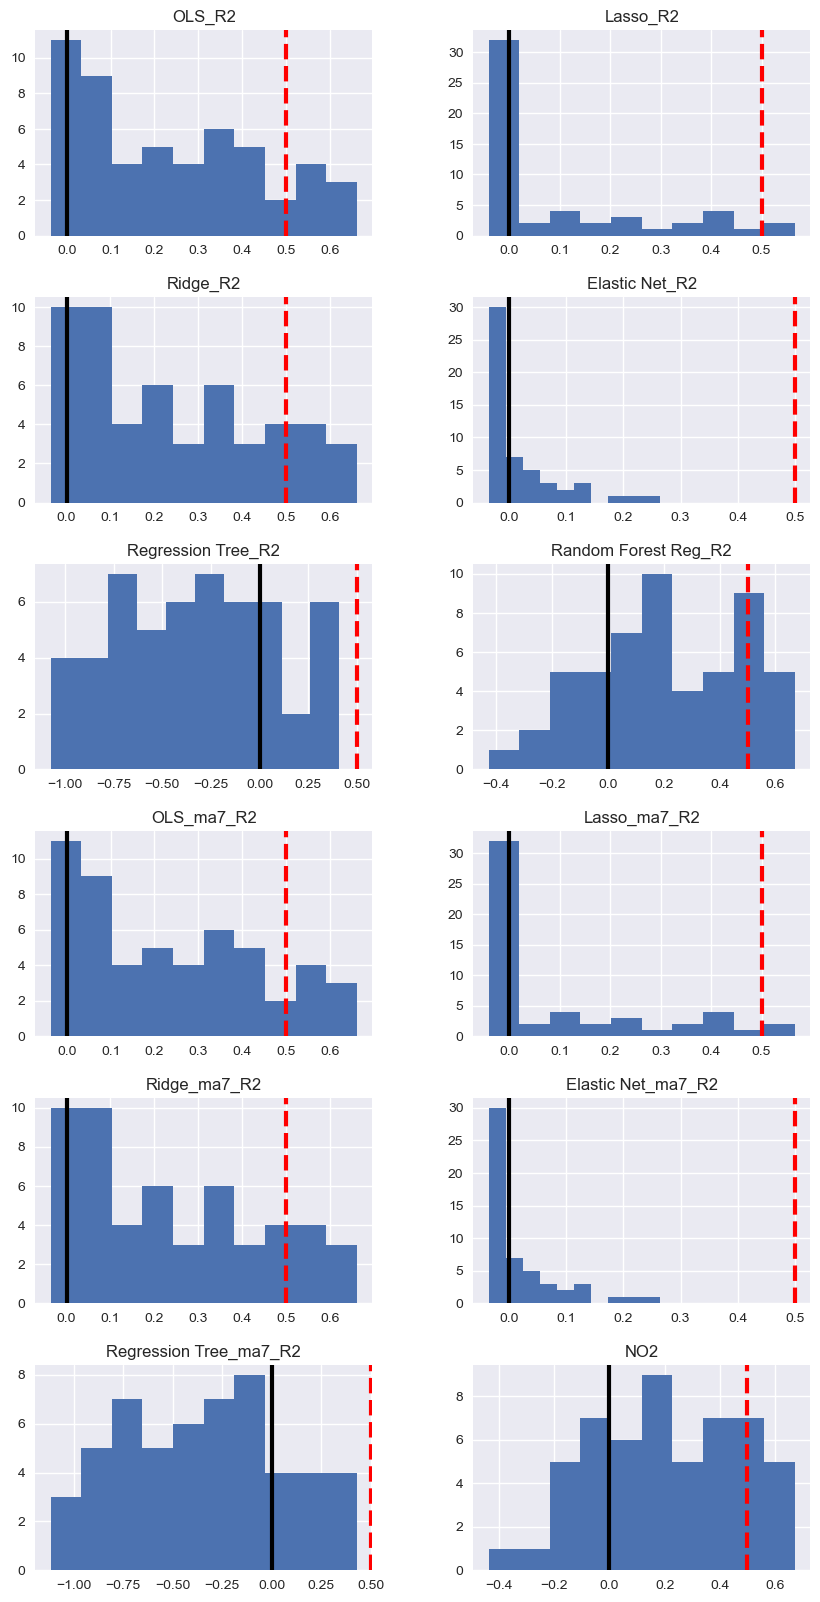

In [10]:
fig = plt.figure(figsize=(10,20))
axs = NO2_df.loc[[bool(regex.match(".*_R2",x)) for x in list(NO2_df.index)]].T.hist(ax=plt.gca(), layout=(6,2))
for ax in axs.flatten():
    ax.axvline(x=0, c="black", linewidth=3)
    ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
plt.title("NO2")

C:\Users\Deyao Kong\AppData\Local\Temp\ipykernel_49544\2709779917.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axs = SO2_df.loc[[bool(regex.match(".*_R2",x)) for x in list(SO2_df.index)]].T.hist(ax=plt.gca())


Text(0.5, 1.0, 'SO2')

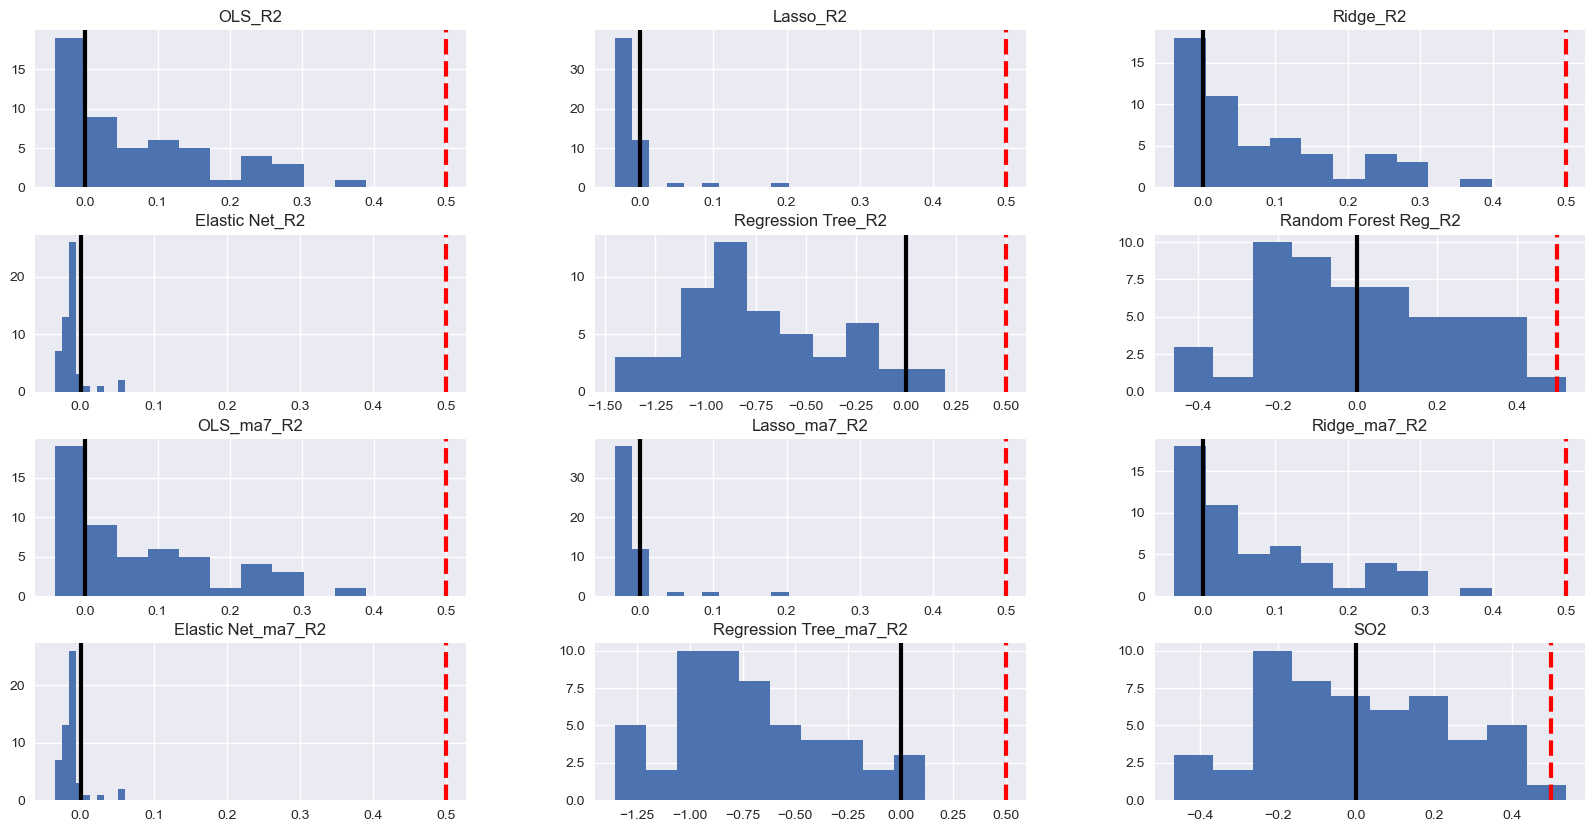

In [11]:
fig = plt.figure(figsize=(20,10))
axs = SO2_df.loc[[bool(regex.match(".*_R2",x)) for x in list(SO2_df.index)]].T.hist(ax=plt.gca())
for ax in axs.flatten():
    ax.axvline(x=0, c="black", linewidth=3)
    ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
plt.title("SO2")

Text(0.5, 1.0, 'NO2')

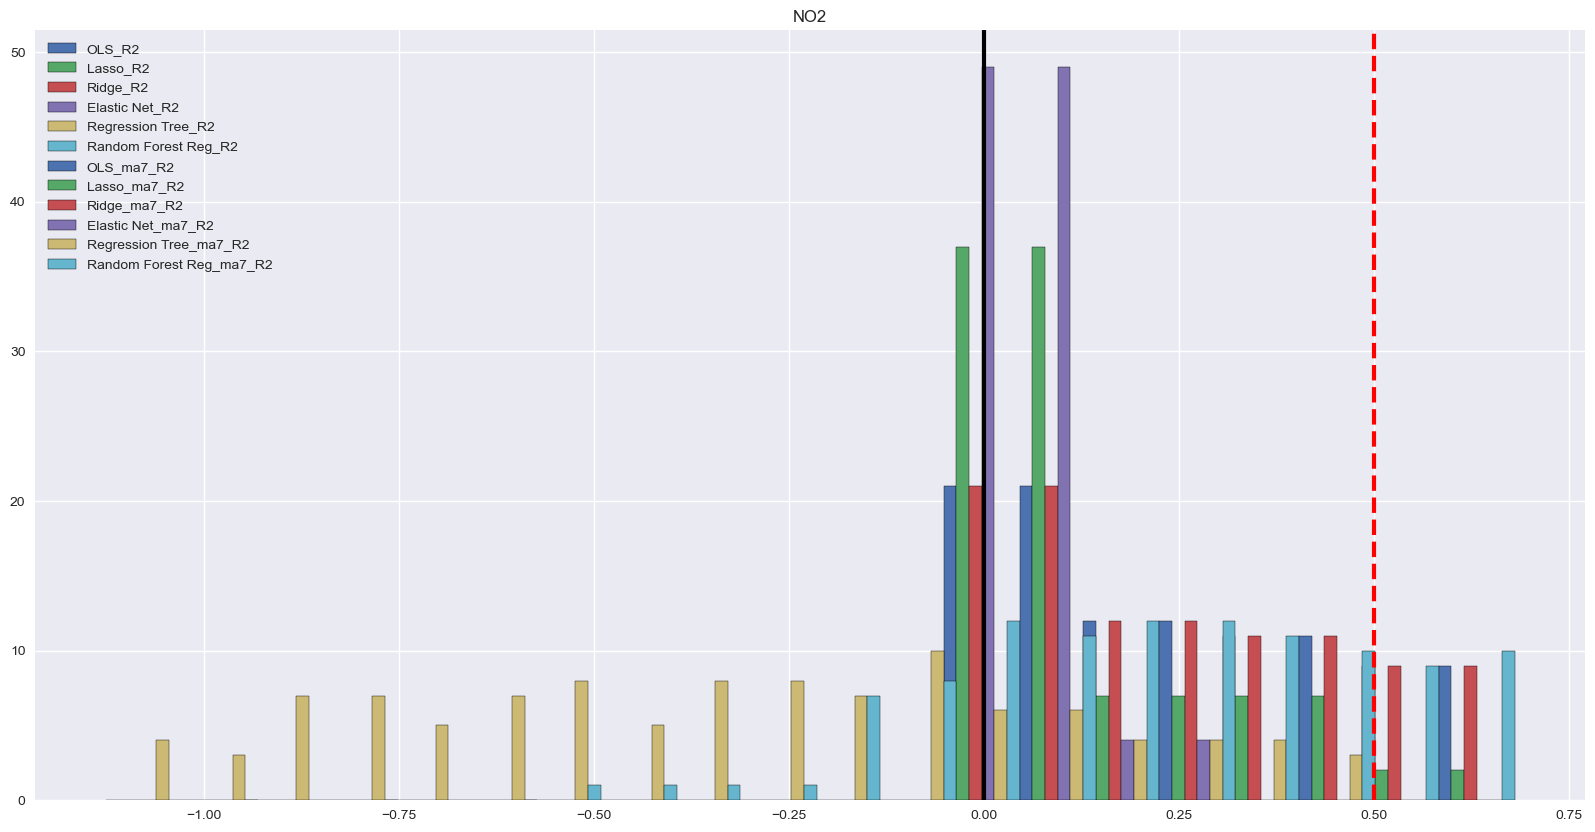

In [12]:
temp = NO2_df.loc[[bool(regex.match(".*_R2",x)) for x in list(NO2_df.index)]].T
_, bins = np.histogram(temp.values.reshape((1,-1)))

plt.figure(figsize=(20, 10))
ax = plt.gca()
width = (bins[1] - bins[0])/len(bins)

for i, column_name in enumerate(temp):
    heights, _ = np.histogram(temp[column_name], bins=bins)
    ax.bar(bins[:-1]+width*i, heights, width=width, label=column_name, edgecolor="black")
plt.legend()
ax=plt.gca()
ax.axvline(x=0, c="black", linewidth=3)
ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
plt.title("NO2")

52
45


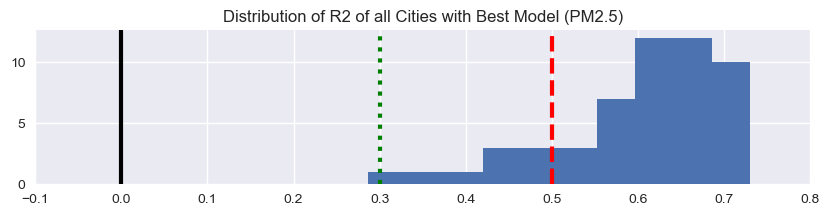

In [13]:
PM25_df = pd.DataFrame(PM25)

plt.figure(figsize=(10,2))
PM25_df.loc[[bool(regex.match(".*_R2", x)) for x in PM25_df["Delhi_PM25"].index]].max().hist(ax=plt.gca())
ax=plt.gca()
ax.axvline(x=0, c="black", linewidth=3)
ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
ax.axvline(x=0.3, c="green", linewidth=3, linestyle=":")
plt.xlim((-0.1, 0.8))
plt.title("Distribution of R2 of all Cities with Best Model (PM2.5)")
print((PM25_df.loc[[bool(regex.match(".*_R2", x)) for x in PM25_df["Delhi_PM25"].index]].max()>0.3).sum())
print((PM25_df.loc[[bool(regex.match(".*_R2", x)) for x in PM25_df["Delhi_PM25"].index]].max()>0.5).sum())

24
11


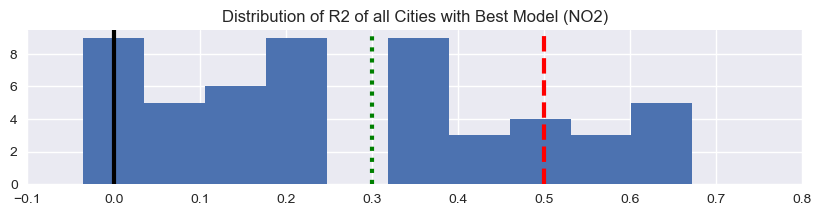

In [14]:
plt.figure(figsize=(10,2))
NO2_df.loc[[bool(regex.match(".*_R2", x)) for x in NO2_df["Delhi_NO2"].index]].max().hist(ax=plt.gca())
ax=plt.gca()
ax.axvline(x=0, c="black", linewidth=3)
ax.axvline(x=0.5, c="red", linewidth=3, linestyle="--")
ax.axvline(x=0.3, c="green", linewidth=3, linestyle=":")
plt.xlim((-0.1, 0.8))
plt.title("Distribution of R2 of all Cities with Best Model (NO2)")
print((NO2_df.loc[[bool(regex.match(".*_R2", x)) for x in NO2_df["Delhi_NO2"].index]].max()>0.3).sum())
print((NO2_df.loc[[bool(regex.match(".*_R2", x)) for x in NO2_df["Delhi_NO2"].index]].max()>0.5).sum())